### Preprocessing

In [ ]:
import os
import json
import zipfile
import tempfile
from glob import glob

import pandas as pd

# --- CONFIG ---
ZIP_FILES = [
    ("walmart_reviews.zip", "round_1_relevance"),
    ("walmart_reviews_asc.zip", "round_2_low_to_high")
]

OUTPUT_DIR = "combined_output"
os.makedirs(OUTPUT_DIR, exist_ok=True)

ALL_PRODUCTS = []
ALL_REVIEWS = []

for zip_path, scrape_label in ZIP_FILES:
    if not os.path.exists(zip_path):
        print(f"⚠️ Zip file not found: {zip_path} — skipping")
        continue

    with tempfile.TemporaryDirectory() as tmpdir:
        with zipfile.ZipFile(zip_path, "r") as z:
            z.extractall(tmpdir)

        for filepath in glob(os.path.join(tmpdir, "**", "*.raw.json"), recursive=True):
            try:
                with open(filepath, "r", encoding="utf-8") as f:
                    data = json.load(f)
            except Exception as e:
                print(f"❌ Failed to read {filepath}: {e}")
                continue

            # --- Product info ---
            product_id = None
            search_params = data.get("search_parameters")
            if isinstance(search_params, dict):
                product_id = search_params.get("product_id")
            elif isinstance(search_params, list) and search_params and isinstance(search_params[0], dict):
                product_id = search_params[0].get("product_id")

            product_name = None
            if isinstance(data.get("product"), dict):
                product_name = data["product"].get("name")

            product_data = {
                "product_id": product_id,
                "product_name": product_name,
                "overall_rating_source": data.get("overall_rating"),
                "total_review_count_source": data.get("total_count"),
                "source_zip": os.path.basename(zip_path),
                "source_label": scrape_label,
                "source_file": os.path.basename(filepath)
            }

            # Flatten ratings counts
            ratings = data.get("ratings", [])
            if isinstance(ratings, list):
                for r in ratings:
                    stars = r.get("stars")
                    count = r.get("count")
                    if stars is not None:
                        product_data[f"rating_{stars}_count_source"] = count

            ALL_PRODUCTS.append(product_data)

            # --- Reviews ---
            reviews = data.get("reviews", []) or []
            for rev in reviews:
                review_data = {
                    "product_id": product_id,
                    "product_name": product_name,
                    "review_position": rev.get("position"),
                    "review_title": rev.get("title"),
                    "review_text": rev.get("text"),
                    "rating": rev.get("rating"),
                    "positive_feedback": rev.get("positive_feedback"),
                    "negative_feedback": rev.get("negative_feedback"),
                    "review_date": rev.get("review_submission_time"),
                    "user_nickname": rev.get("user_nickname"),
                    "verified_purchaser": "VerifiedPurchaser" in (rev.get("customer_type") or []),
                    "source_zip": os.path.basename(zip_path),
                    "source_label": scrape_label,
                    "source_file": os.path.basename(filepath)
                }
                ALL_REVIEWS.append(review_data)

# --- Convert to DataFrames ---
df_products_raw = pd.DataFrame(ALL_PRODUCTS)
df_reviews_raw = pd.DataFrame(ALL_REVIEWS)

# --- STRICT DEDUPLICATION ---
# Drop exact duplicate rows
df_products = df_products_raw.drop_duplicates()
df_reviews = df_reviews_raw.drop_duplicates()

# --- Product-level aggregates ---
if not df_reviews.empty:
    rating_counts = df_reviews.groupby(["product_id", "rating"]).size().unstack(fill_value=0).rename_axis(None, axis=1)
    rating_counts = rating_counts.add_prefix("rating_count_")

    product_agg = df_reviews.groupby("product_id").agg(
        total_reviews_collected=("review_text", "count"),
        avg_rating=("rating", "mean"),
        median_rating=("rating", "median"),
    ).reset_index()

    product_agg = product_agg.merge(rating_counts.reset_index(), on="product_id", how="left")

    # Keep one copy of product info
    df_products_sample = df_products.sort_values("source_label").drop_duplicates(subset=["product_id"], keep="first")
    product_summary = df_products_sample.merge(product_agg, on="product_id", how="outer")
else:
    product_summary = df_products

# --- Save outputs ---
products_out = os.path.join(OUTPUT_DIR, "combined_products_summary.csv")
reviews_out = os.path.join(OUTPUT_DIR, "combined_product_reviews.csv")
df_products_raw.to_csv(os.path.join(OUTPUT_DIR, "raw_products_all.csv"), index=False)
df_reviews_raw.to_csv(os.path.join(OUTPUT_DIR, "raw_reviews_all.csv"), index=False)
product_summary.to_csv(products_out, index=False)
df_reviews.to_csv(reviews_out, index=False)

print(f"✅ Products before dedup: {len(df_products_raw)} → after: {len(df_products)}")
print(f"✅ Reviews before dedup: {len(df_reviews_raw)} → after: {len(df_reviews)}")
print(f"📦 Combined product summary: {products_out}")
print(f"📦 Combined deduped reviews: {reviews_out}")


✅ Products before dedup: 248 → after: 248
✅ Reviews before dedup: 4886 → after: 4886
📦 Combined product summary: combined_output/combined_products_summary.csv
📦 Combined deduped reviews: combined_output/combined_product_reviews.csv


In [ ]:
df_reviews = df_reviews[pd.to_datetime(df_reviews["review_date"], errors="coerce") >= "2022-01-01"]

In [ ]:
df_reviews

product_id                                       product_name  \
1     940310308  Tresemme Pro Pure Leave-in Conditioner Detangl...   
3     940310308  Tresemme Pro Pure Leave-in Conditioner Detangl...   
4     940310308  Tresemme Pro Pure Leave-in Conditioner Detangl...   
5     940310308  Tresemme Pro Pure Leave-in Conditioner Detangl...   
6     940310308  Tresemme Pro Pure Leave-in Conditioner Detangl...   
...         ...                                                ...   
4873   10898766  Vaseline Original Healing Petroleum Jelly Slug...   
4874   10898766  Vaseline Original Healing Petroleum Jelly Slug...   
4875   10898766  Vaseline Original Healing Petroleum Jelly Slug...   
4876   10898766  Vaseline Original Healing Petroleum Jelly Slug...   
4879   10898766  Vaseline Original Healing Petroleum Jelly Slug...   

      review_position                             review_title  \
1                 182              All I will use from now on!   
3                 184                                     None   
4                 185                        Like the product.   
5                 186                            Great product   
6                 187                                    great   
...               ...                                      ...   
4873               88                                     None   
4874               89             Please bring the tube back!!   
4875               90                                     None   
4876               91  Concerned about the lack of safety seal   
4879               94                                     None   

                                            review_text  rating  \
1     It smells so good. It's not sticky. It's light...       5   
3     Great product works very well on my granddaugh...       5   
4     First time I bought this product and I really ...       5   
5     i kove how it leaves my hair soft and manageable.       5   
6                   nice smell\neasy to use\ngood price       5   
...                                                 ...     ...   
4873  The description says this is a pack of 6, but ...       2   
4874  Love this and use it on my lips everyday, but ...       2   
4875  The package came early but when I had got it t...       2   
4876  As other reviews have stated, this product doe...       2   
4879  Produce has not been the best .  The "shoppers...       3   

      positive_feedback  negative_feedback review_date user_nickname  \
1                     0                  0   1/27/2024       WDCHATT   
3                     0                  0   6/20/2023   Conditioner   
4                     0                  0   2/18/2022         Verna   
5                     0                  0   8/15/2023         Janie   
6                     0                  0  11/19/2023         Donna   
...                 ...                ...         ...           ...   
4873                  0                  0  12/15/2023       Charlie   
4874                  7                  1    1/1/2022       Isaac15   
4875                  0                  0   7/29/2023       Markell   
4876                 24                  5    5/4/2023         M2087   
4879                  0                  0    4/3/2025             M   

      verified_purchaser               source_zip         source_label  \
1                   True      walmart_reviews.zip    round_1_relevance   
3                   True      walmart_reviews.zip    round_1_relevance   
4                   True      walmart_reviews.zip    round_1_relevance   
5                   True      walmart_reviews.zip    round_1_relevance   
6                   True      walmart_reviews.zip    round_1_relevance   
...                  ...                      ...                  ...   
4873                True  walmart_reviews_asc.zip  round_2_low_to_high   
4874               False  walmart_reviews_asc.zip  round_2_low_to_high   
4875                True  walmart_r

In [ ]:
df_products.to_csv("products_summary_combined.csv", index=False)
df_reviews.to_csv("product_reviews_combined.csv", index=False)

### Final


In [ ]:
!pip install google-search-results

  Preparing metadata (setup.py) ... done
  Created wheel for google-search-results: filename=google_search_results-2.4.2-py3-none-any.whl size=32010 sha256=467315da6f83df8db842a740cf1e4480cde63ccba3c6c33273ee9b2a945e3b4d
  Stored in directory: /root/.cache/pip/wheels/0c/47/f5/89b7e770ab2996baf8c910e7353d6391e373075a0ac213519e
Successfully built google-search-results


In [ ]:
import json
import requests

# This doesn't use your API key — it's just downloading an existing result
page1_url = "https://serpapi.com/searches/ef46a6621b531e64/688df5b3c986aff24340862d.json"
response = requests.get(page1_url)
page1_data = response.json()

# Extract reviews
page1_reviews = page1_data.get("reviews", [])

# Save as starting file
with open("dove_reviews.json", "w") as f:
    json.dump(page1_reviews, f, indent=2)

print(f"Saved {len(page1_reviews)} reviews from page 1.")


Saved 20 reviews from page 1.


In [ ]:
from serpapi import GoogleSearch
params = {
  "api_key": "",
  "engine": "walmart_product_reviews",
  "product_id": "754211349",
  "page": "1",
  "sort": "submission-desc"
}

search = GoogleSearch(params)
results = search.get_dict()

# Access first result
print(results)

{'search_metadata': {'id': '688e04021a29fecfde5d00c1', 'status': 'Success', 'json_endpoint': 'https://serpapi.com/searches/e9fb147a5832f767/688e04021a29fecfde5d00c1.json', 'created_at': '2025-08-02 12:26:42 UTC', 'processed_at': '2025-08-02 12:26:42 UTC', 'walmart_product_reviews_url': 'https://www.walmart.com/reviews/product/754211349?sort=submission-desc&page=1', 'raw_html_file': 'https://serpapi.com/searches/e9fb147a5832f767/688e04021a29fecfde5d00c1.html', 'prettify_html_file': 'https://serpapi.com/searches/e9fb147a5832f767/688e04021a29fecfde5d00c1.prettify', 'total_time_taken': 0.76}, 'search_parameters': {'product_id': '754211349', 'sort': 'submission-desc', 'page': '1', 'engine': 'walmart_product_reviews'}, 'product': {'name': 'Dove Beauty Bar White 3.75 Ounce (16 Count)', 'url': 'https://www.walmart.com/ip/Dove-Beauty-Bar-White-3-75-Ounce-16-Count/754211349', 'categories': [{'name': 'Personal Care', 'url': 'https://www.walmart.com/cp/personal-care/1005862'}, {'name': 'Bath & Bod

In [ ]:
import os
import json
import re
from serpapi import GoogleSearch

API_KEY = ""
START_PAGE = 1  # Skip page 1 (you already have it)
MAX_PAGES = 10  # Adjust as needed



# Product dictionary (Product Name -> Walmart Product ID)
products = {
    "Lipton Green Tea Bags 100 Ct": "174779977",
    "Lipton Diet Green Tea Citrus 12-Pack": "11960997",
    "Knorr Veg Soup Mix 1.4 oz": "10291773",
    "Hellmann's Mayo 20 oz": "43887962",
    "Magnum Caramel Ice Cream Bars 3 Ct": "17283520",
    "Pond's Cold Cream 6.1 oz": "10804630",
    "Tresemme Curl Mousse 10.5 oz": "10295557",
    "Tresemme Leave-in Conditioner 6.1 oz": "940310308",
    "AXE Apollo Body Wash 32 oz": "728579794",
    "Vaseline Body Oil 13 oz": "10898766",
    "Pepsodent Toothpaste 5.5 oz": "191756851",
    "Dove Deep Moisture Body Wash": "10804694",
    "Dove Intense Repair Shampoo": "9019603356"
}


# Output directory
OUTPUT_DIR = "walmart_reviews"
os.makedirs(OUTPUT_DIR, exist_ok=True)

def sanitize_filename(name):
    return re.sub(r'[^\w\s-]', '', name).replace(" ", "_")

for product_name, product_id in products.items():
    print(f"\n🔍 Processing: {product_name}")
    filename = f"{sanitize_filename(product_name)}.json"
    filepath = os.path.join(OUTPUT_DIR, filename)

    # Load existing reviews if available
    if os.path.exists(filepath):
        with open(filepath, "r") as f:
            all_reviews = json.load(f)
    else:
        all_reviews = []

    for page in range(START_PAGE, START_PAGE + MAX_PAGES):
        print(f"  - Fetching page {page}...")

        params = {
            "api_key": API_KEY,
            "engine": "walmart_product_reviews",
            "product_id": product_id,"sort": "rating-asc",
            "page": str(page)
        }

        try:
            search = GoogleSearch(params)
            results = search.get_dict()

            # Save raw API response (safety backup)
            raw_filename = f"{sanitize_filename(product_name)}_page_{page}.raw.json"
            raw_filepath = os.path.join(OUTPUT_DIR, raw_filename)
            with open(raw_filepath, "w") as raw_file:
                json.dump(results, raw_file, indent=2)

            reviews = results.get("reviews", [])
            if not reviews:
                print(f"    No reviews found on page {page}.")
                break

            all_reviews.extend(reviews)

            with open(filepath, "w") as f:
                json.dump(all_reviews, f, indent=2)

            print(f"    ✅ Saved {len(reviews)} reviews.")
            print(f"    🗂️  Raw response saved to {raw_filename}")

        except Exception as e:
            print(f"    ❌ Error on page {page}: {e}")
            break

    print(f"📦 Finished: {product_name} → {len(all_reviews)} reviews total.")

print("\n✅ All products done.")



🔍 Processing: Lipton Green Tea Bags 100 Ct
  - Fetching page 1...
    ✅ Saved 20 reviews.
    🗂️  Raw response saved to Lipton_Green_Tea_Bags_100_Ct_page_1.raw.json
  - Fetching page 2...
    ✅ Saved 20 reviews.
    🗂️  Raw response saved to Lipton_Green_Tea_Bags_100_Ct_page_2.raw.json
  - Fetching page 3...
    ✅ Saved 20 reviews.
    🗂️  Raw response saved to Lipton_Green_Tea_Bags_100_Ct_page_3.raw.json
  - Fetching page 4...
    ✅ Saved 20 reviews.
    🗂️  Raw response saved to Lipton_Green_Tea_Bags_100_Ct_page_4.raw.json
  - Fetching page 5...
    ✅ Saved 20 reviews.
    🗂️  Raw response saved to Lipton_Green_Tea_Bags_100_Ct_page_5.raw.json
  - Fetching page 6...
    ✅ Saved 20 reviews.
    🗂️  Raw response saved to Lipton_Green_Tea_Bags_100_Ct_page_6.raw.json
  - Fetching page 7...
    ✅ Saved 20 reviews.
    🗂️  Raw response saved to Lipton_Green_Tea_Bags_100_Ct_page_7.raw.json
  - Fetching page 8...
    ✅ Saved 20 reviews.
    🗂️  Raw response saved to Lipton_Green_Tea_Bags_100

In [ ]:
import zipfile

def zip_reviews_folder(folder_path, zip_name="walmart_reviews_asc.zip"):
    zip_path = os.path.join(folder_path, "..", zip_name)
    with zipfile.ZipFile(zip_path, "w", zipfile.ZIP_DEFLATED) as zipf:
        for root, dirs, files in os.walk(folder_path):
            for file in files:
                full_path = os.path.join(root, file)
                arcname = os.path.relpath(full_path, start=folder_path)
                zipf.write(full_path, arcname)
    return zip_path

# Zip the folder
zip_file_path = zip_reviews_folder(OUTPUT_DIR)
print(f"\n📦 Zipped reviews folder to: {zip_file_path}")



📦 Zipped reviews folder to: walmart_reviews/../walmart_reviews_bad.zip


In [ ]:
import os
import json
import pandas as pd

INPUT_DIR = "walmart_reviews"  # folder with raw JSON files (full responses)

import zipfile

# Path to your zip file
ZIP_FILE = "walmart_reviews_asc.zip"

# Step 1: Unpack the zip file into INPUT_DIR
with zipfile.ZipFile(ZIP_FILE, "r") as zip_ref:
    zip_ref.extractall(INPUT_DIR)

print(f"✅ Unzipped files to: {INPUT_DIR}")

PRODUCT_INFO = []
REVIEWS = []

for filename in os.listdir(INPUT_DIR):
    if not filename.endswith(".raw.json"):  # raw files typically have .raw.json extension
        continue

    filepath = os.path.join(INPUT_DIR, filename)
    with open(filepath, "r") as f:
        data = json.load(f)

    # Extract product-level info
    product_data = {
        "product_id": data.get("search_parameters", {}).get("product_id"),
        "product_name": data.get("product", {}).get("name"),
        "overall_rating": data.get("overall_rating"),
        "total_review_count": data.get("total_count")
    }

    # Flatten ratings counts by star
    ratings = data.get("ratings", [])
    for r in ratings:
        product_data[f"rating_{r['stars']}_count"] = r["count"]

    PRODUCT_INFO.append(product_data)

    # Extract all reviews
    reviews = data.get("reviews", [])
    for rev in reviews:
        review_data = {
            "product_id": product_data["product_id"],
            "product_name": product_data["product_name"],
            "review_position": rev.get("position"),
            "review_title": rev.get("title"),
            "review_text": rev.get("text"),
            "rating": rev.get("rating"),
            "positive_feedback": rev.get("positive_feedback"),
            "negative_feedback": rev.get("negative_feedback"),
            "review_date": rev.get("review_submission_time"),
            "user_nickname": rev.get("user_nickname"),
            "verified_purchaser": "VerifiedPurchaser" in rev.get("customer_type", [])
        }
        REVIEWS.append(review_data)

# Convert to DataFrames
df_products = pd.DataFrame(PRODUCT_INFO).drop_duplicates(subset=["product_id"])
df_reviews = pd.DataFrame(REVIEWS)

# Save to CSV
df_products.to_csv("products_summary.csv", index=False)
df_reviews.to_csv("product_reviews.csv", index=False)

print(f"✅ Exported {len(df_products)} products and {len(df_reviews)} reviews to CSV.")


✅ Unzipped files to: walmart_reviews
✅ Exported 13 products and 2444 reviews to CSV.


In [ ]:
# STEP 1: Install Required Libraries (in Colab)
!pip install vaderSentiment

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 126.0/126.0 kB 3.6 MB/s eta 0:00:00


In [ ]:
# Sentiment + keyword pipeline (filter reviews from 2022 onward, product-wise rating counts,
# VADER sentiment scoring, and product-wise top keywords)

import re
from collections import Counter
import pandas as pd
import numpy as np

from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize

# ---------- NLTK downloads (will no-op if already present) ----------
nltk.download('punkt')
nltk.download('punkt_tab')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')

# ---------- Your products mapping (as provided) ----------
products = {
    "Lipton Green Tea Bags 100 Ct": "174779977",
    "Lipton Diet Green Tea Citrus 12-Pack": "11960997",
    "Knorr Veg Soup Mix 1.4 oz": "10291773",
    "Hellmann's Mayo 20 oz": "43887962",
    "Magnum Caramel Ice Cream Bars 3 Ct": "17283520",
    "Pond's Cold Cream 6.1 oz": "10804630",
    "Tresemme Curl Mousse 10.5 oz": "10295557",
    "Tresemme Leave-in Conditioner 6.1 oz": "940310308",
    "AXE Apollo Body Wash 32 oz": "728579794",
    "Vaseline Body Oil 13 oz": "10898766",
    "Pepsodent Toothpaste 5.5 oz": "191756851",
    "Dove Deep Moisture Body Wash": "10804694",
    "Dove Intense Repair Shampoo": "9019603356"
}

# ---------- 1) Prepare DataFrame and apply date filter ----------
reviews_df = pd.read_csv('product_reviews_combined.csv')
reviews_df['review_date'] = pd.to_datetime(reviews_df['review_date'], errors='coerce')
filtered = reviews_df.loc[reviews_df['review_date'] >= pd.to_datetime('2022-01-01')].copy()

# ---------- 2) Normalize product label: map product_id -> readable product name where possible ----------
# Create reverse map from id (int) to product name
reverse_products = {int(v): k for k, v in products.items()}

# create a 'product' column to use consistently: prefer mapped name via product_id, else product_name
filtered['product'] = filtered['product_id'].map(reverse_products)
# fallback to original product_name if mapping not found
filtered['product'] = filtered['product'].fillna(filtered['product_name']).astype(str)

# ---------- 3) Product-wise rating counts (for filtered period) ----------
# This gives a table with products as rows and rating values as columns (counts)
rating_counts = (
    filtered
    .groupby(['product', 'rating'])
    .size()
    .unstack(fill_value=0)
    .sort_index()
)
# Example: rating_counts.loc["Lipton Green Tea Bags 100 Ct", 5] gives # of 5-star reviews for that product

# ---------- 4) VADER sentiment scoring ----------
analyzer = SentimentIntensityAnalyzer()

# Ensure review_text is a string and not null
filtered['review_text'] = filtered['review_text'].fillna('').astype(str)

# compute VADER scores
def vader_scores(text):
    return analyzer.polarity_scores(text)

vader_df = filtered['review_text'].apply(vader_scores).apply(pd.Series)
# columns: 'neg','neu','pos','compound'
filtered = pd.concat([filtered, vader_df], axis=1)

# label by common thresholds
def vader_label(compound):
    if compound >= 0.05:
        return 'positive'
    elif compound <= -0.05:
        return 'negative'
    else:
        return 'neutral'

filtered['vader_label'] = filtered['compound'].apply(vader_label)

# ---------- 5) Product-level sentiment & rating summary ----------
# sentiment distribution per product
sentiment_counts = filtered.groupby(['product', 'vader_label']).size().unstack(fill_value=0)

# mean compound per product + average rating + total reviews
product_stats = filtered.groupby('product').agg(
    total_reviews = ('review_text', 'size'),
    avg_rating = ('rating', 'mean'),
    median_rating = ('rating', 'median'),
    mean_compound = ('compound', 'mean')
).sort_values('total_reviews', ascending=False)

# Combine rating_counts, product_stats and sentiment_counts into a single summary DataFrame
summary = product_stats.join(rating_counts, how='left').join(sentiment_counts, how='left').fillna(0)

# ---------- 6) Keyword extraction (simple frequency-based) ----------
# Preprocessing setup
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()
token_pattern = re.compile(r"[a-zA-Z']{3,}")  # tokens with letters and length >=3

def preprocess_for_keywords(text, extra_stop=None):
    """Lowercase, keep alpha-ish tokens, remove stopwords, lemmatize."""
    if not text:
        return []
    text = text.lower()
    tokens = word_tokenize(text)
    clean = []
    for t in tokens:
        if not token_pattern.fullmatch(t):
            continue

        # Lemmatize first
        t_lem = lemmatizer.lemmatize(t)

        # Then filter by stopwords
        if t_lem in stop_words:
            continue
        if extra_stop and t_lem in extra_stop:
            continue
        if len(t_lem) >= 3:
            clean.append(t_lem)
    return clean

def top_keywords_for_product(df_prod, prod, top_n=20):
    """Return top_n keywords (Counter) for the product's review_text."""
    # Build extra_stopwords from product name tokens to avoid product-name leakage
    prod_tokens = set([t.lower() for t in re.findall(r"[a-zA-Z']{2,}", prod)])
    # collect tokens across reviews
    all_tokens = []
    for text in df_prod['review_text'].fillna(''):
        toks = preprocess_for_keywords(text, extra_stop=prod_tokens)
        all_tokens.extend(toks)
    return Counter(all_tokens).most_common(top_n)


# build dict of top keywords per product
top_keywords = {}
for prod, grp in filtered.groupby('product'):
    top_keywords[prod] = top_keywords_for_product(grp, prod, top_n=20)


# Optional: top keywords split by sentiment per product
top_keywords_by_sentiment = {}
for prod, grp in filtered.groupby('product'):
    by_sent = {}
    for sentiment in ['positive', 'neutral', 'negative']:
        grp_sent = grp[grp['vader_label'] == sentiment]
        by_sent[sentiment] = top_keywords_for_product(grp_sent, prod, top_n=15)
    top_keywords_by_sentiment[prod] = by_sent

# ---------- 7) (Optional) Save outputs or print summaries ----------
# Save summary tables to CSV for inspection, or print small snippets.
summary.to_csv('product_summary.csv')                # combined stats + rating buckets + sentiment counts
rating_counts.to_csv('rating_counts_by_product.csv')
filtered.to_csv('filtered_reviews_with_vader.csv', index=False)

# Print quick console summaries
print("=== Product summary (first 10 rows) ===")
print(summary.head(10).round(3))

print("\n=== Top keywords (example for first 5 products) ===")
for i, (prod, kw) in enumerate(top_keywords.items()):
    print(f"\nProduct: {prod}")
    print(kw[:10])  # show top 10 tokens
    if i >= 4:
        break


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


=== Product summary (first 10 rows) ===
                                      total_reviews  avg_rating  \
product                                                           
Dove Deep Moisture Body Wash                    335       3.066   
Lipton Diet Green Tea Citrus 12-Pack            318       3.057   
AXE Apollo Body Wash 32 oz                      311       4.196   
Dove Intense Repair Shampoo                     298       4.279   
Hellmann's Mayo 20 oz                           298       2.523   
Tresemme Curl Mousse 10.5 oz                    291       3.794   
Knorr Veg Soup Mix 1.4 oz                       282       2.280   
Vaseline Body Oil 13 oz                         257       3.996   
Tresemme Leave-in Conditioner 6.1 oz            244       3.615   
Pond's Cold Cream 6.1 oz                        216       4.356   

                                      median_rating  mean_compound    1   2  \
product                                                                     

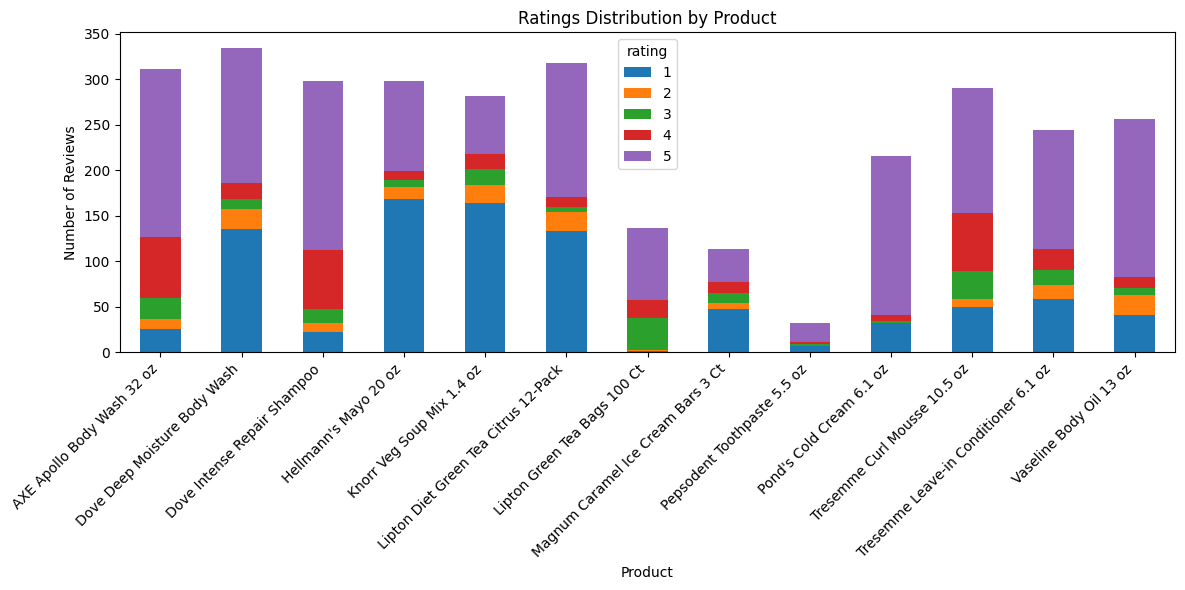

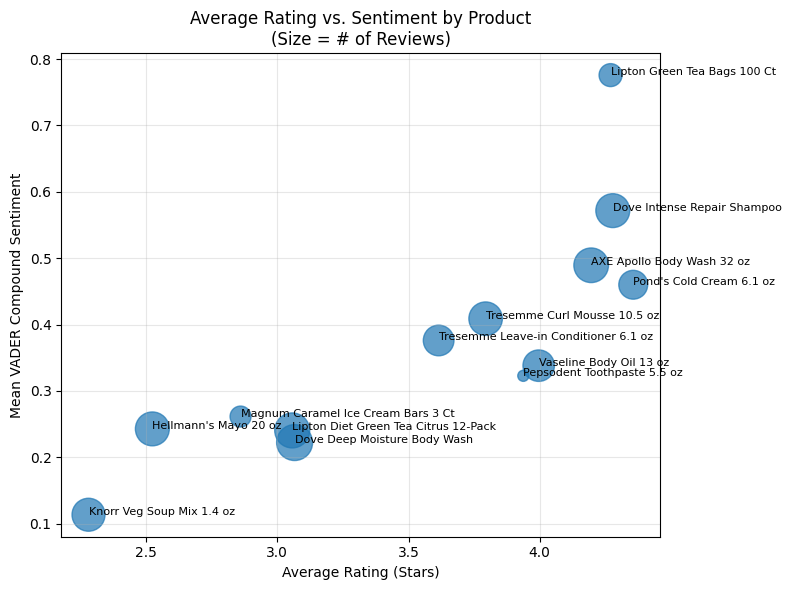

In [ ]:
import matplotlib.pyplot as plt

# ---------- 1) Ratings distribution per product ----------
rating_counts.plot(
    kind="bar",
    stacked=True,
    figsize=(12, 6),
    title="Ratings Distribution by Product"
)
plt.ylabel("Number of Reviews")
plt.xlabel("Product")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()

# ---------- 2) Sentiment distribution per product ----------
sentiment_counts.plot(
    kind="bar",
    stacked=True,
    figsize=(12, 6),
    title="Sentiment Distribution by Product"
)
plt.ylabel("Number of Reviews")
plt.xlabel("Product")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()

# ---------- 3) Average rating vs. Mean sentiment ----------
plt.figure(figsize=(8, 6))
plt.scatter(summary['avg_rating'], summary['mean_compound'], s=summary['total_reviews']*2, alpha=0.7)
for i, txt in enumerate(summary.index):
    plt.annotate(txt, (summary['avg_rating'].iloc[i], summary['mean_compound'].iloc[i]), fontsize=8)
plt.xlabel("Average Rating (Stars)")
plt.ylabel("Mean VADER Compound Sentiment")
plt.title("Average Rating vs. Sentiment by Product\n(Size = # of Reviews)")
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# ---------- 4) Top keywords per product ----------
# def plot_top_keywords(product_name, top_n=10):
#     if product_name not in top_keywords:
#         print(f"No keywords for {product_name}")
#         return
#     kws = dict(top_keywords[product_name][:top_n])
#     plt.figure(figsize=(8, 5))
#     plt.barh(list(kws.keys()), list(kws.values()))
#     plt.title(f"Top {top_n} Keywords for {product_name}")
#     plt.xlabel("Frequency")
#     plt.gca().invert_yaxis()  # highest at top
#     plt.tight_layout()
#     plt.show()

# # Example: plot keywords for first product in summary
# example_product = summary.index[0]
# plot_top_keywords(example_product, top_n=10)


/tmp/ipython-input-1035399930.py:41: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='rating', y='compound', data=filtered, palette='Set2')


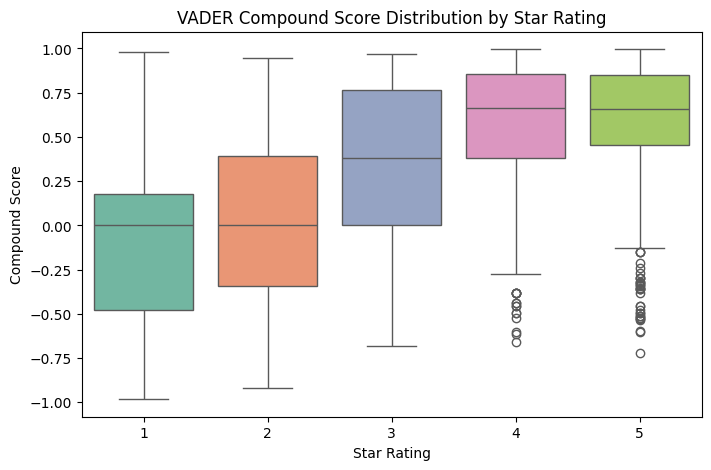

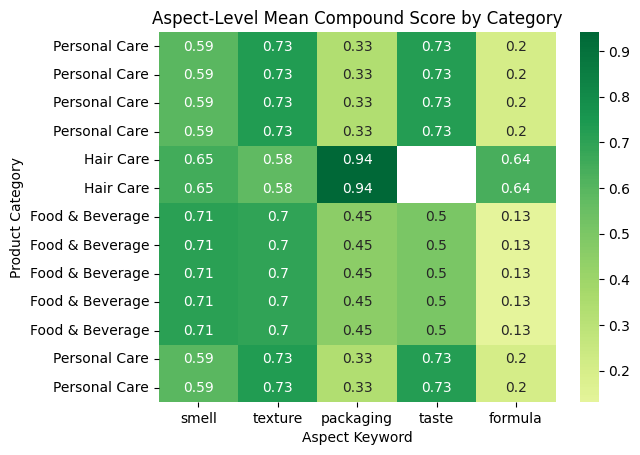

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import networkx as nx
from collections import Counter

# Load preprocessed DataFrame
filtered = pd.read_csv('filtered_reviews_with_vader.csv')
summary = pd.read_csv('product_summary.csv', index_col=0)

# Ensure consistent product_category mapping
category_map = {
    'Dove Deep Moisture Body Wash': 'Personal Care',
    'Dove Intense Repair Shampoo': 'Personal Care',
    'AXE Apollo Body Wash 32 oz': 'Personal Care',
    "Pond's Cold Cream 6.1 oz": 'Personal Care',
    'Tresemme Curl Mousse 10.5 oz': 'Hair Care',
    'Tresemme Leave-in Conditioner 6.1 oz': 'Hair Care',
    'Lipton Green Tea Bags 100 Ct': 'Foods',
    'Lipton Diet Green Tea Citrus 12-Pack': 'Food & Beverage',
    'Knorr Veg Soup Mix 1.4 oz': 'Food & Beverage',
    "Hellmann's Mayo 20 oz": 'Food & Beverage',
    'Magnum Caramel Ice Cream Bars 3 Ct': 'Food & Beverage',
    'Vaseline Body Oil 13 oz': 'Personal Care',
    'Pepsodent Toothpaste 5.5 oz': 'Personal Care'
}
filtered['product_category'] = filtered['product'].map(category_map)

# 1. Rating–Sentiment Divergence Heatmap
pivot = filtered.pivot_table(index='rating', columns='vader_label',
                             values='review_text', aggfunc='count').fillna(0)
sns.heatmap(pivot, annot=True, fmt='g', cmap='YlGnBu')
plt.title('Rating vs VADER Label Distribution')
plt.ylabel('Star Rating')
plt.xlabel('VADER Label')
plt.show()

# 2. Compound Score Distribution Box Plots by Rating
plt.figure(figsize=(8,5))
sns.boxplot(x='rating', y='compound', data=filtered, palette='Set2')
plt.title('VADER Compound Score Distribution by Star Rating')
plt.xlabel('Star Rating')
plt.ylabel('Compound Score')
plt.show()

# 3. Aspect–Sentiment Heatmap by Category
# Use top_keywords_by_sentiment computed earlier (dict of dict)
# Compute aspect sentiment means
aspects = ['smell','texture','packaging','taste','formula']
heatmap_data = pd.DataFrame(index=category_map.values(), columns=aspects)
for cat in heatmap_data.index:
    prods = [p for p,c in category_map.items() if c==cat]
    for aspect in aspects:
        mask = filtered['product'].isin(prods) & filtered['review_text'].str.contains(aspect, case=False)
        heatmap_data.loc[cat, aspect] = filtered.loc[mask, 'compound'].mean()
heatmap_data = heatmap_data.astype(float)
sns.heatmap(heatmap_data, annot=True, cmap='RdYlGn', center=0)
plt.title('Aspect-Level Mean Compound Score by Category')
plt.xlabel('Aspect Keyword')
plt.ylabel('Product Category')
plt.show()




In [ ]:
!pip install gensim

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.0/61.0 kB 3.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.6/60.6 kB 4.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 26.6/26.6 MB 69.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.0/18.0 MB 81.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 38.2/38.2 MB 19.8 MB/s eta 0:00:00
  Attempting uninstall: numpy
    Found existing installation: numpy 2.0.2
    Uninstalling numpy-2.0.2:
      Successfully uninstalled numpy-2.0.2
  Attempting uninstall: scipy
    Found existing installation: scipy 1.16.1
    Uninstalling scipy-1.16.1:
      Successfully uninstalled scipy-1.16.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
opencv-contrib-python 4.12.0.88 requires numpy<2.3.0,>=2; python_version >= "3.9", but you have numpy 1.26.4 which is incompatibl

In [ ]:
import gensim
from gensim import corpora
from gensim.models import LdaModel

# Tokenize preprocessed review_text
tokenized_texts = filtered['review_text'].map(preprocess_for_keywords).tolist()

# Build dictionary and corpus
dictionary = corpora.Dictionary(tokenized_texts)
corpus = [dictionary.doc2bow(text) for text in tokenized_texts]

# Train LDA
lda_model = LdaModel(corpus=corpus,
                     id2word=dictionary,
                     num_topics=5,       # you can experiment with this number
                     random_state=42,
                     passes=10,
                     alpha='auto')

# Show topics
topics = lda_model.print_topics(num_words=10)
for topic_no, topic in topics:
    print(f"Topic {topic_no}: {topic}")


Topic 0: 0.037*"dip" + 0.027*"recipe" + 0.022*"soup" + 0.018*"package" + 0.016*"skin" + 0.016*"make" + 0.015*"back" + 0.014*"mix" + 0.014*"vegetable" + 0.012*"n't"
Topic 1: 0.046*"hair" + 0.029*"product" + 0.024*"smell" + 0.019*"great" + 0.017*"good" + 0.016*"shampoo" + 0.014*"review" + 0.013*"use" + 0.013*"body" + 0.012*"love"
Topic 2: 0.017*"n't" + 0.016*"product" + 0.013*"cream" + 0.012*"like" + 0.011*"caramel" + 0.011*"taste" + 0.010*"love" + 0.009*"ice" + 0.009*"good" + 0.009*"mayonnaise"
Topic 3: 0.053*"tea" + 0.029*"green" + 0.017*"like" + 0.014*"drink" + 0.014*"lipton" + 0.014*"flavor" + 0.013*"n't" + 0.013*"taste" + 0.013*"good" + 0.011*"diet"
Topic 4: 0.022*"n't" + 0.018*"product" + 0.014*"bottle" + 0.012*"one" + 0.012*"year" + 0.011*"new" + 0.010*"like" + 0.010*"used" + 0.009*"item" + 0.008*"use"


In [ ]:
# Get topic distribution per document
topic_distributions = [lda_model.get_document_topics(bow) for bow in corpus]

# Assign dominant topic per review
dominant_topics = [max(dist, key=lambda x: x[1])[0] if dist else -1 for dist in topic_distributions]

# Add to DataFrame
filtered['dominant_topic'] = dominant_topics

# Example: topic distribution per product
topic_summary = (
    filtered.groupby(['product', 'dominant_topic'])
    .size()
    .unstack(fill_value=0)
)

print(topic_summary.head())


dominant_topic                  0    1    2   3    4
product                                             
AXE Apollo Body Wash 32 oz     10  189   36  11   65
Dove Deep Moisture Body Wash   68  135   34   4   94
Dove Intense Repair Shampoo     9  217   30   2   40
Hellmann's Mayo 20 oz          12   40  125  16  105
Knorr Veg Soup Mix 1.4 oz     211   10   19  27   15


In [ ]:
topic_summary_full = filtered.groupby(['product', 'dominant_topic']).size().unstack(fill_value=0)
print(topic_summary_full)


dominant_topic                          0    1    2    3    4
product                                                      
AXE Apollo Body Wash 32 oz             10  189   36   11   65
Dove Deep Moisture Body Wash           68  135   34    4   94
Dove Intense Repair Shampoo             9  217   30    2   40
Hellmann's Mayo 20 oz                  12   40  125   16  105
Knorr Veg Soup Mix 1.4 oz             211   10   19   27   15
Lipton Diet Green Tea Citrus 12-Pack    7   11   53  148   99
Lipton Green Tea Bags 100 Ct            1    4    4  123    5
Magnum Caramel Ice Cream Bars 3 Ct      1    7   87    5   14
Pepsodent Toothpaste 5.5 oz             0    0   10    3   19
Pond's Cold Cream 6.1 oz               19   60   28    5  104
Tresemme Curl Mousse 10.5 oz            2  214   21   13   41
Tresemme Leave-in Conditioner 6.1 oz    4  167   25    9   39
Vaseline Body Oil 13 oz                27   60   69   10   91


In [ ]:
# Cross-tab of dominant_topic vs vader_label
topic_sentiment = filtered.groupby(['dominant_topic', 'vader_label']).size().unstack(fill_value=0)

# Also compute proportions per topic
topic_sentiment_pct = topic_sentiment.div(topic_sentiment.sum(axis=1), axis=0)

print(topic_sentiment)
print(topic_sentiment_pct.round(3))  # Rounded percentages


vader_label     negative  neutral  positive
dominant_topic                             
0                    137       33       201
1                     96      128       890
2                    112       65       364
3                     38       54       284
4                    205      161       365
vader_label     negative  neutral  positive
dominant_topic                             
0                  0.369    0.089     0.542
1                  0.086    0.115     0.799
2                  0.207    0.120     0.673
3                  0.101    0.144     0.755
4                  0.280    0.220     0.499


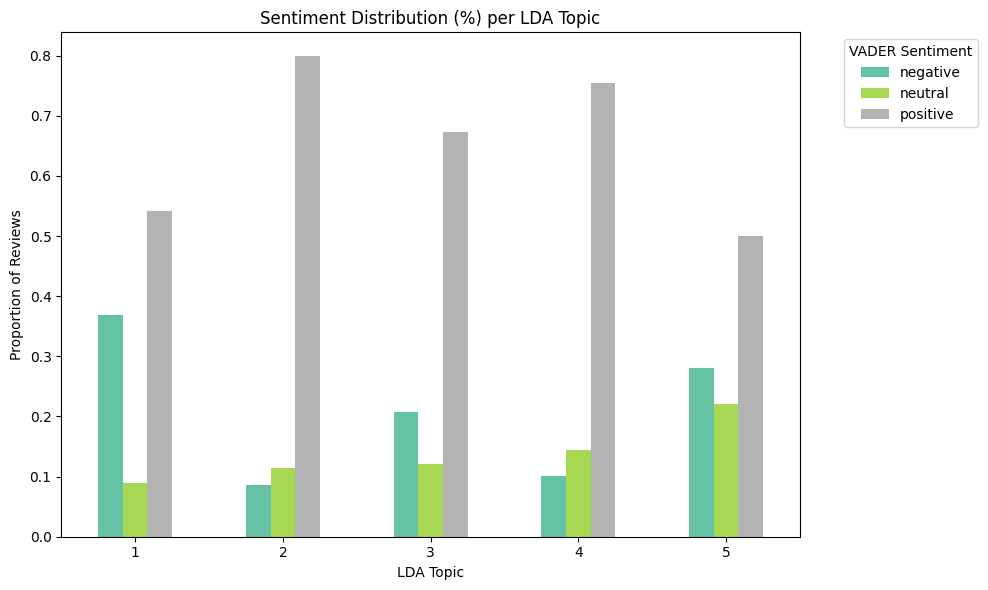

In [ ]:
# Shift the index for display purposes
topic_sentiment_pct.index = topic_sentiment_pct.index + 1

# Plot
topic_sentiment_pct.plot(kind='bar', figsize=(10,6), colormap='Set2')
plt.title('Sentiment Distribution (%) per LDA Topic')
plt.ylabel('Proportion of Reviews')
plt.xlabel('LDA Topic')
plt.xticks(rotation=0)
plt.legend(title='VADER Sentiment', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()


### Mid Term

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


Loaded Reviews: (2444, 11)
Loaded Ratings Summary: (13, 9)
Topic 1: dip, back, cream, recipe, ice, caramel, make, soup, package, please
Topic 2: tea, green, like, taste, good, flavor, lipton, drink, one, would
Topic 3: review, part, promotion, collected, skin, like, product, cream, face, cold
Topic 4: hair, product, review, part, collected, promotion, good, great, dry, use
Topic 5: body, wash, new, product, dove, one, bottle, formula, like, years

=== Sentiment vs Ratings Comparison ===
   product_id                                       product_name  \
0    10291773  Knorr No Artificial Flavors Vegetable Recipe S...   
1    10295557  Tresemme Nourishing Mousse Flawless Curls with...   
2    10804630  Pond's Cold Cream Cleanser & Make-Up Remover 6...   
3    10804694  Dove Moisturizing Liquid Body Wash Cleanser fo...   
4    10898766  Vaseline Original Healing Petroleum Jelly Slug...   

   overall_rating  percent_positive  
0             3.9              49.0  
1             4.5      

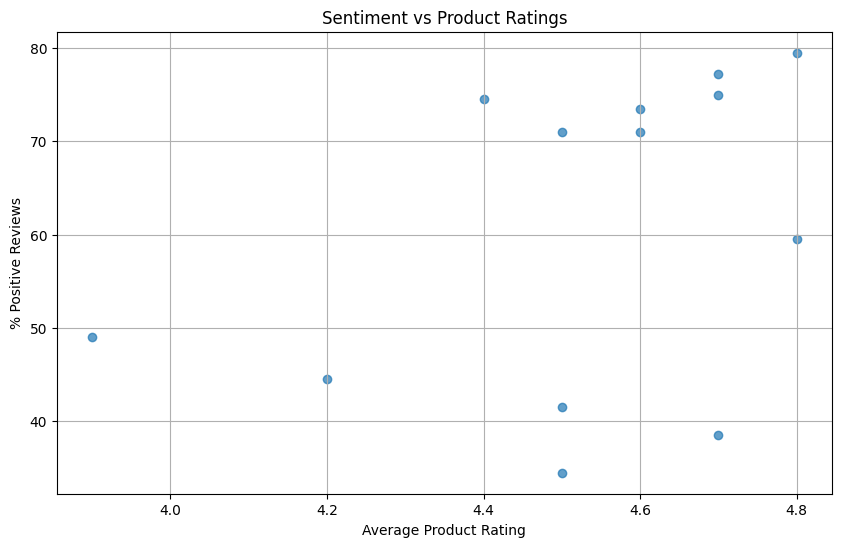

In [ ]:


import pandas as pd
import nltk
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation
import matplotlib.pyplot as plt


# Download NLTK stopwords
nltk.download('stopwords')
from nltk.corpus import stopwords

# STEP 2: Load Your Data
# Upload your files in Colab sidebar and set paths here:
reviews_file = '/content/product_reviews.csv'  # Review-level data
ratings_file = '/content/products_summary.csv'  # Aggregate summary

# Read CSVs
reviews_df = pd.read_csv(reviews_file)
ratings_df = pd.read_csv(ratings_file)

# Optional: display basic info
print("Loaded Reviews:", reviews_df.shape)
print("Loaded Ratings Summary:", ratings_df.shape)

# -----------------------
# STEP 3: Sentiment Analysis
# -----------------------

def analyze_sentiment(df, text_col):
    """Add sentiment label ('positive', 'neutral', 'negative') to DataFrame based on text."""
    analyzer = SentimentIntensityAnalyzer()

    def get_sentiment_label(text):
        if not isinstance(text, str) or text.strip() == '':
            return 'neutral'
        score = analyzer.polarity_scores(text)['compound']
        if score >= 0.05:
            return 'positive'
        elif score <= -0.05:
            return 'negative'
        else:
            return 'neutral'

    df['sentiment'] = df[text_col].apply(get_sentiment_label)
    return df

reviews_df = analyze_sentiment(reviews_df, 'review_text')

# -----------------------
# STEP 4: Topic Modeling
# -----------------------

def run_topic_modeling(text_series, n_topics=5, max_features=1000, no_top_words=10):
    """Performs LDA topic modeling on provided text data."""
    stop_words = stopwords.words('english')
    vectorizer = CountVectorizer(stop_words=stop_words, max_df=0.95, min_df=5, max_features=max_features)
    dtm = vectorizer.fit_transform(text_series.fillna(''))

    lda = LatentDirichletAllocation(n_components=n_topics, random_state=42)
    lda.fit(dtm)

    feature_names = vectorizer.get_feature_names_out()

    # Display topics
    for idx, topic in enumerate(lda.components_):
        top_words = [feature_names[i] for i in topic.argsort()[:-no_top_words-1:-1]]
        print(f"Topic {idx+1}: {', '.join(top_words)}")

run_topic_modeling(reviews_df['review_text'], n_topics=5)

# -----------------------
# STEP 5: Aggregate & Compare Sentiment vs Ratings
# -----------------------

def summarize_sentiment_vs_ratings(reviews_df, ratings_df):
    """Combines sentiment analysis with product ratings for comparison."""
    # % of positive reviews by product
    sentiment_summary = (
        reviews_df.groupby('product_id')['sentiment']
        .apply(lambda x: (x == 'positive').sum() / len(x) * 100)
        .reset_index(name='percent_positive')
    )

    # Merge with rating summary
    merged = pd.merge(sentiment_summary, ratings_df, on='product_id', how='left')

    summary = merged[['product_id', 'product_name', 'overall_rating', 'percent_positive']].copy()
    return summary

comparison_df = summarize_sentiment_vs_ratings(reviews_df, ratings_df)
print("\n=== Sentiment vs Ratings Comparison ===")
print(comparison_df.head())

# Save result
comparison_df.to_csv('sentiment_vs_ratings_summary.csv', index=False)
# print("\nSaved summary as 'sentiment_vs_ratings_summary.csv'")

# Optional visualization
def plot_sentiment_vs_rating(df):
    plt.figure(figsize=(10,6))
    plt.scatter(df['overall_rating'], df['percent_positive'], alpha=0.7)
    plt.xlabel('Average Product Rating')
    plt.ylabel('% Positive Reviews')
    plt.title('Sentiment vs Product Ratings')
    plt.grid(True)
    plt.show()

plot_sentiment_vs_rating(comparison_df)


In [ ]:
import re
import pandas as pd
import nltk
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation
import matplotlib.pyplot as plt

# NLTK setup
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

# -----------------------
# STEP 1: Load Data
# -----------------------
reviews_file = '/content/product_reviews.csv'  # Review-level data
ratings_file = '/content/products_summary.csv'  # Aggregate summary

reviews_df = pd.read_csv(reviews_file)
ratings_df = pd.read_csv(ratings_file)

print("Loaded Reviews:", reviews_df.shape)
print("Loaded Ratings Summary:", ratings_df.shape)


Loaded Reviews: (2442, 11)
Loaded Ratings Summary: (13, 9)


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [ ]:

# -----------------------
# STEP 2: Text Cleaning
# -----------------------
def clean_text(text, for_sentiment=True):
    if not isinstance(text, str):
        return ""
    # Remove HTML tags
    text = re.sub(r'<.*?>', ' ', text)
    # Remove URLs
    text = re.sub(r'http\S+|www\S+', '', text)
    # Remove extra spaces
    text = re.sub(r'\s+', ' ', text).strip()

    if not for_sentiment:
        # Lowercase for topic modeling
        text = text.lower()
        # Remove punctuation/numbers
        text = re.sub(r'[^a-z\s]', '', text)
        # Remove stopwords
        text = ' '.join([word for word in text.split() if word not in stop_words])
        # Lemmatization
        text = ' '.join([lemmatizer.lemmatize(word) for word in text.split()])

    return text

# Two separate cleaned versions
reviews_df['review_text_clean_sentiment'] = reviews_df['review_text'].apply(lambda x: clean_text(x, for_sentiment=True))
reviews_df['review_text_clean_topics'] = reviews_df['review_text'].apply(lambda x: clean_text(x, for_sentiment=False))

# Date conversion
reviews_df['review_date'] = pd.to_datetime(reviews_df['review_date'], format='mixed', errors='coerce')

# -----------------------
# STEP 3: Sentiment Analysis
# -----------------------
def analyze_sentiment(df, text_col):
    analyzer = SentimentIntensityAnalyzer()

    def get_sentiment_label(text):
        if not isinstance(text, str) or text.strip() == '':
            return 'neutral'
        score = analyzer.polarity_scores(text)['compound']
        if score >= 0.05:
            return 'positive'
        elif score <= -0.05:
            return 'negative'
        else:
            return 'neutral'

    df['sentiment'] = df[text_col].apply(get_sentiment_label)
    return df

reviews_df = analyze_sentiment(reviews_df, 'review_text_clean_sentiment')

# -----------------------
# STEP 4: Topic Modeling
# -----------------------
def run_topic_modeling(text_series, n_topics=5, max_features=1000, no_top_words=10):
    vectorizer = CountVectorizer(
        stop_words='english',
        max_df=0.95,
        min_df=5,
        max_features=max_features
    )

    dtm = vectorizer.fit_transform(text_series.fillna(''))

    lda = LatentDirichletAllocation(n_components=n_topics, random_state=42)
    lda.fit(dtm)

    feature_names = vectorizer.get_feature_names_out()
    for idx, topic in enumerate(lda.components_):
        top_words = [feature_names[i] for i in topic.argsort()[:-no_top_words-1:-1]]
        print(f"Topic {idx+1}: {', '.join(top_words)}")

run_topic_modeling(reviews_df['review_text_clean_topics'], n_topics=5)

# -----------------------
# STEP 5: Sentiment vs Ratings Comparison
# -----------------------
def summarize_sentiment_vs_ratings(reviews_df, ratings_df):
    sentiment_summary = (
        reviews_df.groupby('product_id')['sentiment']
        .apply(lambda x: (x == 'positive').sum() / len(x) * 100)
        .reset_index(name='percent_positive')
    )
    merged = pd.merge(sentiment_summary, ratings_df, on='product_id', how='left')
    return merged[['product_id', 'product_name', 'overall_rating', 'percent_positive']]

comparison_df = summarize_sentiment_vs_ratings(reviews_df, ratings_df)
print("\n=== Sentiment vs Ratings Comparison ===")

# comparison_df.to_csv('sentiment_vs_ratings_summary.csv', index=False)



Topic 1: cream, ice, bar, caramel, chocolate, buy, like, love, order, walmart
Topic 2: skin, dip, make, recipe, body, wash, mix, use, package, spinach
Topic 3: year, product, used, use, love, using, great, best, ive, mayonnaise
Topic 4: hair, product, smell, great, good, shampoo, love, feel, work, like
Topic 5: tea, green, taste, lipton, flavor, drink, like, good, great, love

=== Sentiment vs Ratings Comparison ===


product_id                                       product_name  \
0    10291773  Knorr No Artificial Flavors Vegetable Recipe S...   
1    10295557  Tresemme Nourishing Mousse Flawless Curls with...   
2    10804630  Pond's Cold Cream Cleanser & Make-Up Remover 6...   
3    10804694  Dove Moisturizing Liquid Body Wash Cleanser fo...   
4    10898766  Vaseline Original Healing Petroleum Jelly Slug...   

   overall_rating  percent_positive  
0             3.8              69.0  
1             4.5              71.5  
2             4.2              83.0  
3             4.7              75.0  
4             4.8              76.5

from matplotlib import pyplot as plt
_df_20['product_id'].plot(kind='hist', bins=20, title='product_id')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_21['overall_rating'].plot(kind='hist', bins=20, title='overall_rating')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_22['percent_positive'].plot(kind='hist', bins=20, title='percent_positive')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
import seaborn as sns
_df_23.groupby('product_name').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_24.plot(kind='scatter', x='product_id', y='overall_rating', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_25.plot(kind='scatter', x='overall_rating', y='percent_positive', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  xs = series['product_id']
  ys = series['overall_rating']
  
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = _df_26.sort_values('product_id', ascending=True)
for i, (series_name, series) in enumerate(df_sorted.groupby('product_name')):
  _plot_series(series, series_name, i)
  fig.legend(title='product_name', bbox_to_anchor=(1, 1), loc='upper left')
sns.despine(fig=fig, ax=ax)
plt.xlabel('product_id')
_ = plt.ylabel('overall_rating')

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  xs = series['product_id']
  ys = series['percent_positive']
  
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = _df_27.sort_values('product_id', ascending=True)
for i, (series_name, series) in enumerate(df_sorted.groupby('product_name')):
  _plot_series(series, series_name, i)
  fig.legend(title='product_name', bbox_to_anchor=(1, 1), loc='upper left')
sns.despine(fig=fig, ax=ax)
plt.xlabel('product_id')
_ = plt.ylabel('percent_positive')

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  counted = (series['product_id']
                .value_counts()
              .reset_index(name='counts')
              .rename({'index': 'product_id'}, axis=1)
              .sort_values('product_id', ascending=True))
  xs = counted['product_id']
  ys = counted['counts']
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = _df_28.sort_values('product_id', ascending=True)
for i, (series_name, series) in enumerate(df_sorted.groupby('product_name')):
  _plot_series(series, series_name, i)
  fig.legend(title='product_name', bbox_to_anchor=(1, 1), loc='upper left')
sns.despine(fig=fig, ax=ax)
plt.xlabel('product_id')
_ = plt.ylabel('count()')

from matplotlib import pyplot as plt
_df_29['product_id'].plot(kind='line', figsize=(8, 4), title='product_id')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
_df_30['overall_rating'].plot(kind='line', figsize=(8, 4), title='overall_rating')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
_df_31['percent_positive'].plot(kind='line', figsize=(8, 4), title='percent_positive')
plt.gca().spines[['top', 'right']].set_visible(False)

<string>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.



from matplotlib import pyplot as plt
import seaborn as sns
figsize = (12, 1.2 * len(_df_32['product_name'].unique()))
plt.figure(figsize=figsize)
sns.violinplot(_df_32, x='product_id', y='product_name', inner='stick', palette='Dark2')
sns.despine(top=True, right=True, bottom=True, left=True)

<string>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.



from matplotlib import pyplot as plt
import seaborn as sns
figsize = (12, 1.2 * len(_df_33['product_name'].unique()))
plt.figure(figsize=figsize)
sns.violinplot(_df_33, x='overall_rating', y='product_name', inner='stick', palette='Dark2')
sns.despine(top=True, right=True, bottom=True, left=True)

<string>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.



from matplotlib import pyplot as plt
import seaborn as sns
figsize = (12, 1.2 * len(_df_34['product_name'].unique()))
plt.figure(figsize=figsize)
sns.violinplot(_df_34, x='percent_positive', y='product_name', inner='stick', palette='Dark2')
sns.despine(top=True, right=True, bottom=True, left=True)

In [ ]:
reviews_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2444 entries, 0 to 2443
Data columns (total 12 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   product_id          2444 non-null   int64         
 1   product_name        2244 non-null   object        
 2   review_position     2444 non-null   int64         
 3   review_title        1826 non-null   object        
 4   review_text         2432 non-null   object        
 5   rating              2444 non-null   int64         
 6   positive_feedback   2444 non-null   int64         
 7   negative_feedback   2444 non-null   int64         
 8   review_date         2444 non-null   datetime64[ns]
 9   user_nickname       2376 non-null   object        
 10  verified_purchaser  2444 non-null   bool          
 11  sentiment           2444 non-null   object        
dtypes: bool(1), datetime64[ns](1), int64(5), object(5)
memory usage: 212.5+ KB


In [ ]:
reviews_df_temp = pd.read_csv(reviews_file)
reviews_df_temp.head(2)
#reviews_df[['rating','positive_feedback','negative_feedback']].describe().T.round(2)

product_id                                       product_name  \
0    10291773  Knorr No Artificial Flavors Vegetable Recipe S...   
1    10291773  Knorr No Artificial Flavors Vegetable Recipe S...   

   review_position           review_title  \
0               41  Picture is misleading   
1               42        What is this???   

                                         review_text  rating  \
0  I bought this thinking that it would make the ...       2   
1  I agree with so many of these reviews.  I neve...       1   

   positive_feedback  negative_feedback review_date user_nickname  \
0                 28                  4  11-02-2022  anonymous098   
1                  0                  0  02-09-2025     TatersMom   

   verified_purchaser  
0               False  
1               False

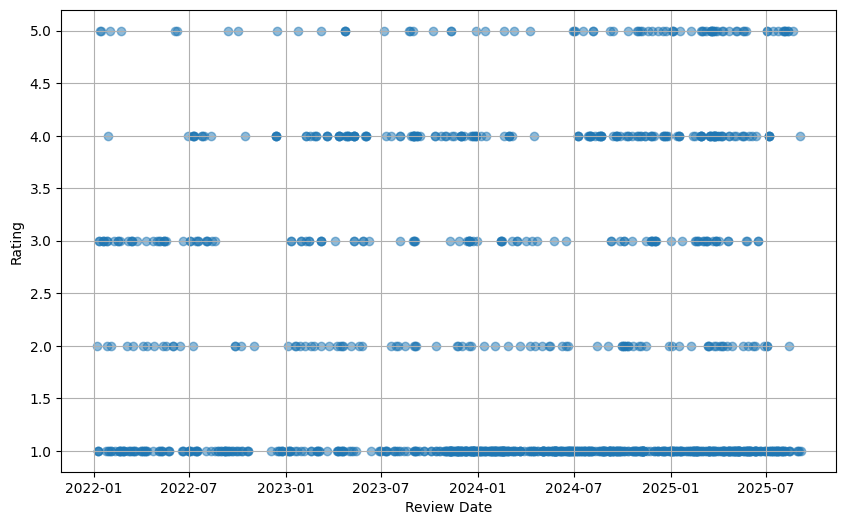

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# ensure datetime
reviews_df['review_date'] = pd.to_datetime(reviews_df['review_date'], format='mixed', errors='coerce')

# filter reviews after 2022
filtered = reviews_df[reviews_df['review_date'] > pd.to_datetime("2022-01-01")]

# scatter plot
plt.figure(figsize=(10, 6))
plt.scatter(filtered['review_date'], filtered['rating'], alpha=0.5)
plt.xlabel('Review Date')
plt.ylabel('Rating')
plt.grid(True)
plt.show()



In [ ]:
import matplotlib.pyplot as plt

# Truncate long product names
ratings_df['short_name'] = ratings_df['product_name'].apply(lambda x: x[:15] + '...' if len(x) > 15 else x)

rating_cols = [f"rating_{i}_count" for i in range(1, 6)]

# Plot with truncated names
ratings_df.set_index('short_name')[rating_cols].plot(
    kind='bar',
    stacked=True,
    figsize=(10, 6)
)

plt.xlabel('Product Name')
plt.ylabel('Number of Ratings')
# plt.title('Rating Distribution per Product')
plt.legend(title='Rating')

# Make labels inclined
plt.xticks(rotation=45, ha='right')

plt.tight_layout()
plt.show()


/tmp/ipython-input-4092934410.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df, x="rating", order=sorted(df["rating"].unique()), palette="Blues")


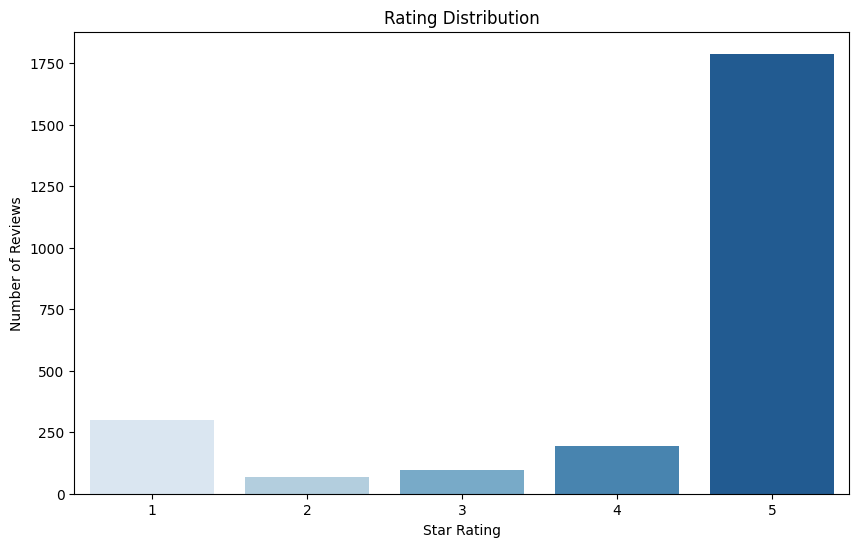

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
sns.countplot(data=df, x="rating", order=sorted(df["rating"].unique()), palette="Blues")
plt.title("Rating Distribution")
plt.xlabel("Star Rating")
plt.ylabel("Number of Reviews")
plt.show()


In [ ]:
df["sentiment"] = df["rating"].apply(lambda x: "positive" if x >= 4 else "neutral" if x == 3 else "negative")
df["sentiment"].value_counts(normalize=True).plot.pie(autopct='%1.1f%%', figsize=(6, 6), title="Sentiment Breakdown")


<Axes: title={'center': 'Sentiment Breakdown'}, ylabel='proportion'>